# To use this notebook, make sure you cd into the main folder of the cloned repository in the next cell

In [226]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


## folder variables

In [247]:
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/31-01-2022/800/800/first"
wantedCSVfilename = "data-batch-vs-acc-800-800.csv"

## Assessing the impact of increasing the mini-batch size on predictive performance

In [248]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from collections import Counter
import os
import math
import random
pd.set_option('display.max_rows', 300)

**Method that is used for parsing a moa output log file**

- Open file and get columns index for wanted statistics.
- Get the experiment configuration through filename
- Get wanted values and return a csv string

In [249]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

**Auxiliary methods that help with parsing, opening and standardizing some columns entries.**

In [250]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [251]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [252]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
#     return df[df['algorithm'].str.contains(string, regex=False)]
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

**Auxiliary methods for chart generation**


In [253]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']

    labels = df.batch_size
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    
    ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
    ax.plot(x,pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')

    #ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [254]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']

    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'covtypeNorm': 'covtypeNorm', 'airlines': 'Airlines'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(['batch_size']), alg)
            if tables:
                display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Batch sizes')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

**main portion of the code**

- % operator is a bash command. Change into the desired directory, where the result files are located.
- Opens the csv file that will store all parsed strings.
- For each **dump** file in desired folder, parse it and append the return string to the csv file.
- Open a df from this csv and drop cores and time columns.

In [255]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
df = df.drop(['cores', 'time'], axis=1)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/2209187601.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, index_col=False)
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")

**show charts**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


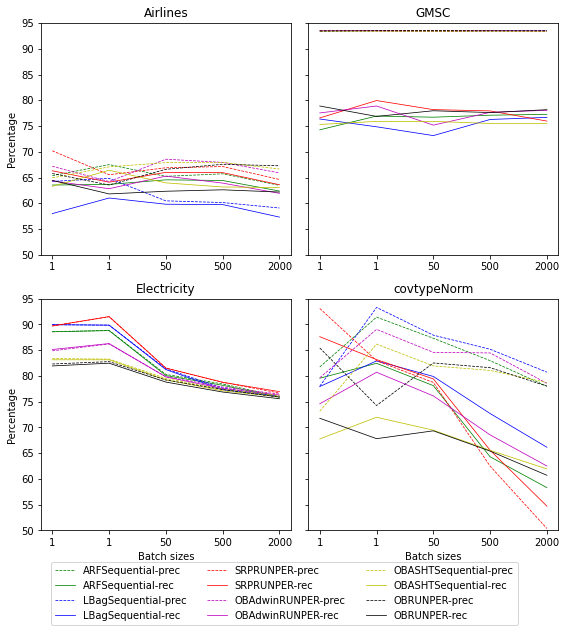

In [256]:
#false makes the chart without markers
gen_chart(df,False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


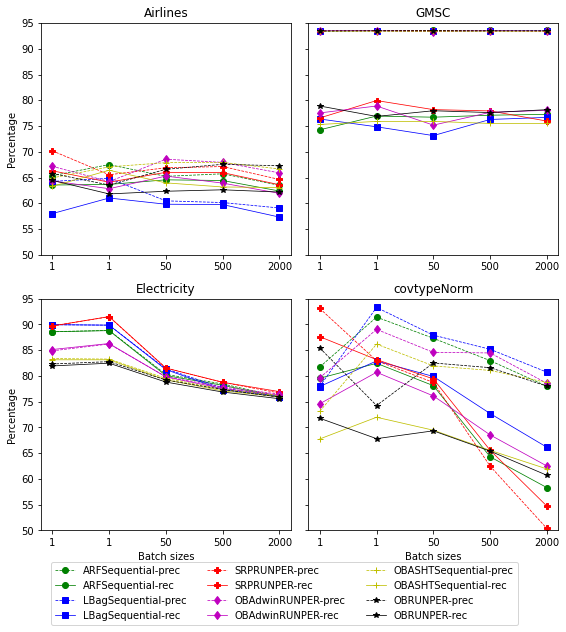

In [257]:
#by default, chart is generated with markers
gen_chart(df)

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
32,airlines,ARFSequential,25,1,1,125.477997,65.356295,63.546425,60.724196
118,airlines,ARFRUNPER,25,1,1,1368.979004,67.510274,63.662252,61.823866
41,airlines,ARFMB,25,50,1,120.140999,65.230769,64.555038,63.852695
55,airlines,ARFMB,25,500,1,121.036003,65.725581,64.421925,63.461447
40,airlines,ARFMB,25,2000,1,125.835999,63.490000,62.380313,61.786765


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
7,airlines,LBagSequential,25,1,1,126.896004,64.254237,57.996836,55.460027
22,airlines,LBagRUNPER,25,1,1,1665.313965,64.836477,61.024049,58.992393
48,airlines,LBagMB,25,50,1,120.050003,60.472603,59.818793,58.885152
57,airlines,LBagMB,25,500,1,121.174004,60.142857,59.751586,58.837629
90,airlines,LBagMB,25,2000,1,125.265999,59.085000,57.320146,56.459128


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
116,airlines,SRPRUNPER,25,1,1,957.091003,70.191246,66.308701,60.902446
113,airlines,SRPSequential,25,1,1,124.831001,65.542453,64.094145,60.481397
46,airlines,SRPMB,25,50,1,120.033997,66.893827,66.010336,64.695421
16,airlines,SRPMB,25,500,1,120.200996,67.133333,65.951312,64.028567
102,airlines,SRPMB,25,2000,1,122.233002,64.625000,63.604108,62.699221


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
88,airlines,OBAdwinRUNPER,25,1,1,1026.613037,67.183754,64.337603,61.512595
85,airlines,OBAdwinSequential,25,1,1,126.105003,64.211787,62.832638,61.611383
59,airlines,OBAdwinMB,25,50,1,120.181000,68.558011,65.278544,60.384525
44,airlines,OBAdwinMB,25,500,1,120.223999,67.938182,63.917552,60.648035
119,airlines,OBAdwinMB,25,2000,1,121.301003,65.905769,61.934078,60.385994


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
103,airlines,OBASHTSequential,25,1,1,126.119003,64.933452,63.290825,61.714594
66,airlines,OBASHTRUNPER,25,1,1,562.661987,67.068850,66.410901,62.789484
107,airlines,OBASHTMB,25,50,1,120.030998,67.888686,63.964641,60.508003
101,airlines,OBASHTMB,25,500,1,120.166000,67.937748,63.168269,60.376438
33,airlines,OBASHTMB,25,2000,1,120.486000,66.657000,63.060553,59.962047


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
60,airlines,OBRUNPER,25,1,1,352.881989,65.781904,64.452884,61.260941
86,airlines,OBSequential,25,1,1,128.009003,63.546911,61.816677,60.539505
3,airlines,OBMB,25,50,1,120.003998,66.597418,62.337715,60.108015
91,airlines,OBMB,25,500,1,120.128998,67.566265,62.618295,60.028153
76,airlines,OBMB,25,2000,1,120.084999,67.281250,62.182620,59.733483


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
56,GMSC,ARFSequential,25,1,1,122.375000,93.406950,74.264202,53.341769
14,GMSC,ARFRUNPER,25,1,1,225.054001,93.522000,76.935435,54.402225
23,GMSC,ARFMB,25,50,1,120.002998,93.544448,76.712864,54.307765
28,GMSC,ARFMB,25,500,1,120.191002,93.544366,77.101928,54.311924
19,GMSC,ARFMB,25,2000,1,120.352997,93.546622,77.265159,54.935080


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
77,GMSC,LBagRUNPER,25,1,1,168.757996,93.542000,76.361278,55.403724
35,GMSC,LBagSequential,25,1,1,121.735001,93.486635,74.850953,54.183296
106,GMSC,LBagMB,25,50,1,105.885002,93.358453,73.142029,52.982166
71,GMSC,LBagMB,25,500,1,95.285004,93.483612,76.273854,54.093661
109,GMSC,LBagMB,25,2000,1,106.202003,93.534459,76.676140,55.172096


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
5,GMSC,SRPSequential,25,1,1,122.377998,93.495775,76.570728,51.912907
78,GMSC,SRPRUNPER,25,1,1,452.009003,93.532667,79.943197,53.194926
12,GMSC,SRPMB,25,50,1,120.046997,93.495220,78.184244,52.471350
115,GMSC,SRPMB,25,500,1,121.462997,93.495652,77.931419,52.488127
95,GMSC,SRPMB,25,2000,1,120.730003,93.402703,75.956925,52.318677


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
83,GMSC,OBAdwinRUNPER,25,1,1,102.069000,93.480000,77.540578,53.162077
73,GMSC,OBAdwinSequential,25,1,1,90.862999,93.446000,78.886369,52.111408
72,GMSC,OBAdwinMB,25,50,1,40.209000,93.342447,75.175147,50.755007
74,GMSC,OBAdwinMB,25,500,1,36.875000,93.474916,77.652137,53.081561
97,GMSC,OBAdwinMB,25,2000,1,39.058998,93.466892,78.053452,52.920674


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
49,GMSC,OBASHTRUNPER,25,1,1,80.807999,93.403333,75.3,51.7
24,GMSC,OBASHTSequential,25,1,1,67.859001,93.326667,75.9,51.6
87,GMSC,OBASHTMB,25,50,1,36.771999,93.375792,75.9,51.1
21,GMSC,OBASHTMB,25,500,1,31.098000,93.359197,75.5,51.6
65,GMSC,OBASHTMB,25,2000,1,33.653999,93.398649,75.5,51.2


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
70,GMSC,OBSequential,25,1,1,67.049004,93.446000,78.886369,52.111408
81,GMSC,OBRUNPER,25,1,1,84.109001,93.500000,76.864196,53.959863
34,GMSC,OBMB,25,50,1,39.257000,93.500500,77.964737,53.359337
38,GMSC,OBMB,25,500,1,33.828999,93.479599,77.611830,53.190849
69,GMSC,OBMB,25,2000,1,37.208000,93.472297,78.171796,52.975087


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
36,elecNormNew,ARFSequential,25,1,1,121.628998,88.585543,88.559247,87.834326
11,elecNormNew,ARFRUNPER,25,1,1,96.628998,88.819739,88.787064,88.256554
50,elecNormNew,ARFMB,25,50,1,58.160000,80.285891,80.057014,79.324509
51,elecNormNew,ARFMB,25,500,1,56.152000,78.427653,78.174428,77.311207
79,elecNormNew,ARFMB,25,2000,1,57.736000,75.985870,75.844074,74.551722


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
64,elecNormNew,LBagRUNPER,25,1,1,67.237000,89.927613,89.937878,89.388884
6,elecNormNew,LBagSequential,25,1,1,89.009003,89.845957,89.849325,89.309074
93,elecNormNew,LBagMB,25,50,1,43.070000,81.372896,81.220708,80.408198
45,elecNormNew,LBagMB,25,500,1,40.068001,77.635455,77.317939,76.530496
94,elecNormNew,LBagMB,25,2000,1,41.463001,75.965091,75.924838,74.423015


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
25,elecNormNew,SRPRUNPER,25,1,1,176.542999,89.687059,89.683114,89.147835
105,elecNormNew,SRPSequential,25,1,1,122.251999,91.469309,91.514769,91.137421
75,elecNormNew,SRPMB,25,50,1,117.217003,81.529760,81.513050,80.431833
30,elecNormNew,SRPMB,25,500,1,117.974998,78.748996,78.761160,77.367156
17,elecNormNew,SRPMB,25,2000,1,115.982002,76.666975,76.942383,74.929257


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
39,elecNormNew,OBAdwinSequential,25,1,1,37.522999,84.858316,85.115472,83.780554
53,elecNormNew,OBAdwinRUNPER,25,1,1,42.523998,86.191296,86.277391,85.344993
37,elecNormNew,OBAdwinMB,25,50,1,21.660999,79.837391,79.797325,78.618054
63,elecNormNew,OBAdwinMB,25,500,1,21.006001,77.836294,77.536072,76.726364
110,elecNormNew,OBAdwinMB,25,2000,1,19.653000,76.456871,76.260799,75.135520


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
0,elecNormNew,OBASHTRUNPER,25,1,1,33.511002,83.359816,83.123349,82.668029
15,elecNormNew,OBASHTSequential,25,1,1,28.938000,83.256091,83.118814,82.425905
29,elecNormNew,OBASHTMB,25,50,1,16.730000,79.508197,79.235223,78.537548
108,elecNormNew,OBASHTMB,25,500,1,15.025000,77.401143,77.092388,76.257760
47,elecNormNew,OBASHTMB,25,2000,1,18.931999,76.165959,75.926316,74.868171


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
67,elecNormNew,OBRUNPER,25,1,1,32.792,82.304908,81.927662,81.787568
82,elecNormNew,OBSequential,25,1,1,27.441,82.761741,82.461972,82.123155
2,elecNormNew,OBMB,25,50,1,16.466,79.194468,78.797607,78.412445
20,elecNormNew,OBMB,25,500,1,14.922,77.347585,76.861816,76.563192
27,elecNormNew,OBMB,25,2000,1,17.413,75.872737,75.563589,74.638715


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
58,covtypeNorm,ARFSequential,25,1,1,121.450996,81.723320,79.545769,79.151989
9,covtypeNorm,ARFRUNPER,25,1,1,390.572998,91.404543,82.438557,79.435440
54,covtypeNorm,ARFMB,25,50,1,120.079002,87.297468,78.100609,76.323177
100,covtypeNorm,ARFMB,25,500,1,120.223000,82.956204,64.284651,60.695074
96,covtypeNorm,ARFMB,25,2000,1,121.064003,77.979032,58.302884,51.209744


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
112,covtypeNorm,LBagSequential,25,1,1,121.103996,77.995803,77.930398,77.868798
61,covtypeNorm,LBagRUNPER,25,1,1,471.605011,93.286096,82.901329,82.113970
114,covtypeNorm,LBagMB,25,50,1,120.032997,87.900935,79.886094,77.833639
18,covtypeNorm,LBagMB,25,500,1,120.487000,85.163793,72.686642,66.722800
42,covtypeNorm,LBagMB,25,2000,1,123.263000,80.719643,66.140662,59.221969


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
1,covtypeNorm,SRPRUNPER,25,1,1,527.809021,93.078641,87.607212,87.401827
80,covtypeNorm,SRPSequential,25,1,1,121.959999,82.933833,83.158376,82.037749
68,covtypeNorm,SRPMB,25,50,1,120.029999,78.730159,79.413698,78.304429
10,covtypeNorm,SRPMB,25,500,1,121.208000,62.476471,65.560065,61.240641
99,covtypeNorm,SRPMB,25,2000,1,128.348999,50.371429,54.710321,49.846083


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
31,covtypeNorm,OBAdwinSequential,25,1,1,120.869003,79.634772,74.585646,75.067507
13,covtypeNorm,OBAdwinRUNPER,25,1,1,279.141998,89.024410,80.698592,79.769027
117,covtypeNorm,OBAdwinMB,25,50,1,120.009003,84.566265,76.107912,73.988266
84,covtypeNorm,OBAdwinMB,25,500,1,120.174004,84.451685,68.540313,66.185343
98,covtypeNorm,OBAdwinMB,25,2000,1,120.996002,78.557143,62.499458,57.649862


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
111,covtypeNorm,OBASHTSequential,25,1,1,120.500999,73.120238,67.756734,70.714134
26,covtypeNorm,OBASHTRUNPER,25,1,1,221.281998,86.165765,71.966291,74.597450
52,covtypeNorm,OBASHTMB,25,50,1,120.001999,81.938802,69.452096,70.892893
43,covtypeNorm,OBASHTMB,25,500,1,120.359001,81.056000,65.541529,63.977838
89,covtypeNorm,OBASHTMB,25,2000,1,122.102997,78.713953,61.933042,56.760254


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
92,covtypeNorm,OBRUNPER,25,1,1,217.800003,85.415730,71.769271,74.325362
62,covtypeNorm,OBSequential,25,1,1,120.481003,74.241020,67.809544,70.797063
104,covtypeNorm,OBMB,25,50,1,120.058998,82.503667,69.330281,70.901197
8,covtypeNorm,OBMB,25,500,1,120.228996,81.590110,65.396236,63.926630
4,covtypeNorm,OBMB,25,2000,1,121.643997,78.007955,60.699425,56.363973


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


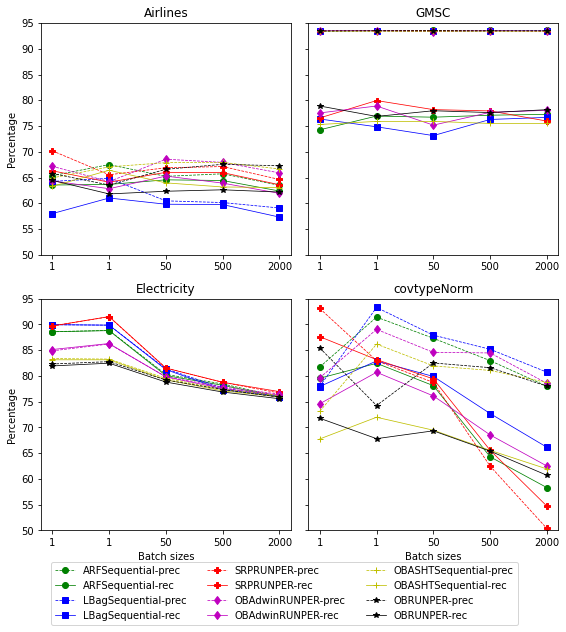

In [258]:
#by default, chart is generated with markers
#the modifier tables outputs the tables used for each serie of the chart
gen_chart(df, tables=True)